In [117]:
import os 
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [118]:
#load in training data. We will use this as both train and test, and save 'test.json' for validation
data = pd.read_json('data/train/train.json').rename(columns = {'requester_received_pizza': 'target'})
drop_cols = [col for col in data.columns if 'retrieval' in col]
data = data.drop(columns=drop_cols)

#Change the boolean target variable to an int
data['target'] = data['target'].astype(int)

#Get a rough idea of target baseline
baseline = round(sum(data['target']) / len(data['target']), 2)
print(f'Roughly {int(baseline * 100)}% of requests receive pizza.')

Roughly 25% of requests receive pizza.


In [119]:
#The most basic possible model - extract only int variables, no transformations
int_data = data.select_dtypes(np.number)
y = int_data['target']
X = int_data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Default randomforest with cross validation
baseline_clf = RandomForestClassifier(max_depth=5, random_state=0)
scores = cross_val_score(baseline_clf, X_train, y_train, cv=5)

In [120]:
print(f'Baseline model accuracy: {round(np.mean(scores), 2) * 100}%')

Baseline model accuracy: 76.0%


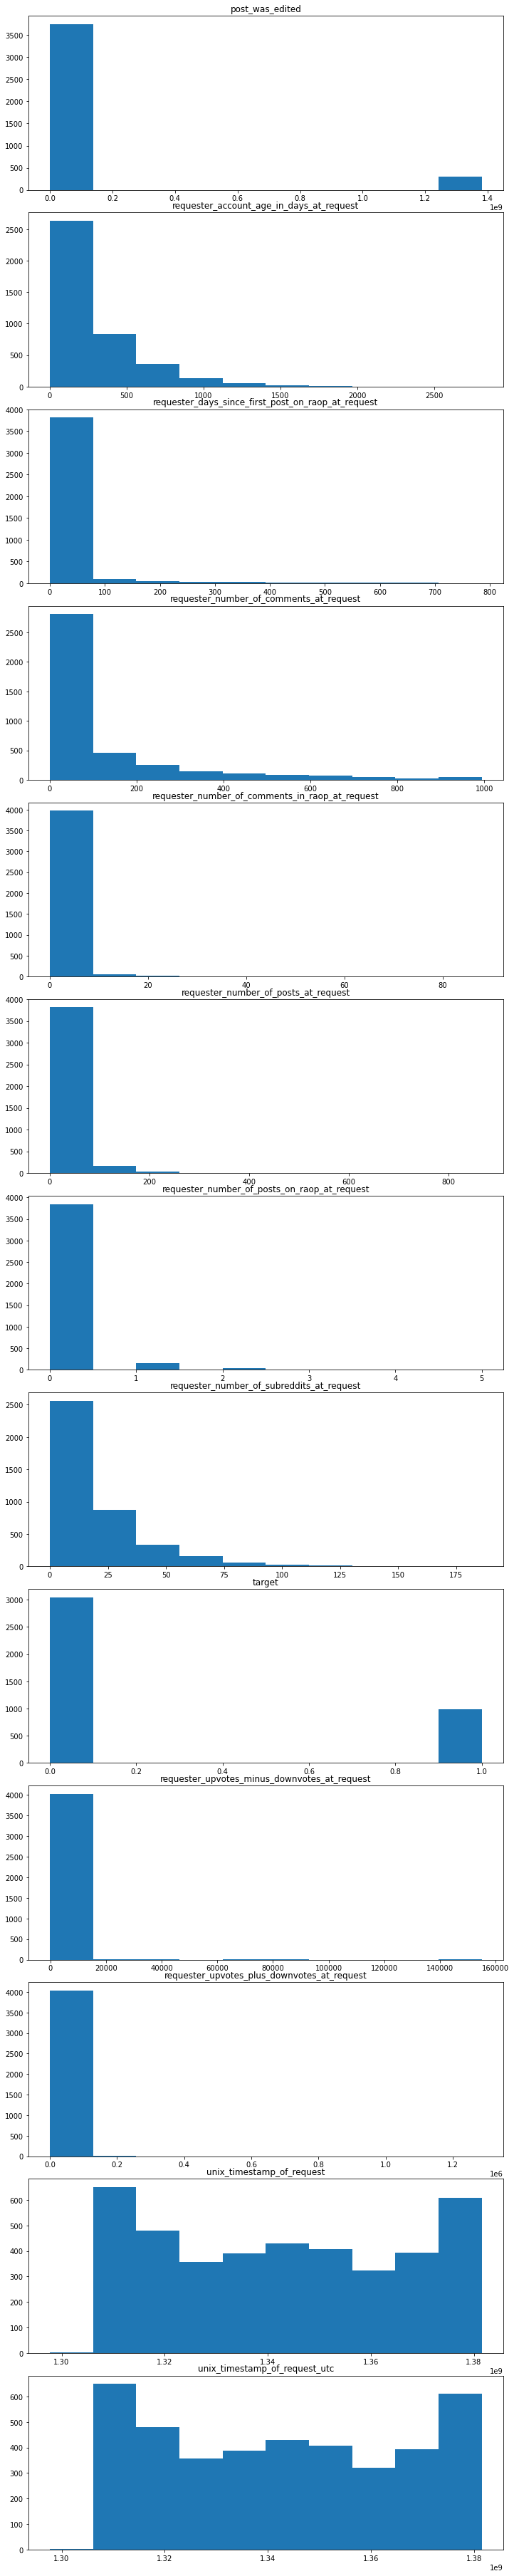

In [121]:
fig, axs = plt.subplots(len(int_data.columns), figsize=(10,50))
#fig.suptitle('Data Distributions')
fig.tight_layout()
for i in range(len(int_data.columns)):
    axs[i].hist(int_data[int_data.columns[i]])
    axs[i].set_title(int_data.columns[i])


In [122]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [127]:
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.2s


KeyboardInterrupt: 

In [124]:
#Default randomforest with cross validation
optimized_clf = RandomForestClassifier(bootstrap=True, max_depth=80,max_features=3,min_samples_leaf=3,min_samples_split=8,n_estimators=200)
scores = cross_val_score(baseline_clf, X_train, y_train, cv=5)
print(f'Optimized model accuracy: {round(np.mean(scores), 2) * 100}%')

Optimized model accuracy: 76.0%


In [125]:
#The most basic possible model - extract only int variables, no transformations
transformers = [
    preprocessing.StandardScaler(),
    preprocessing.Normalizer(),
    preprocessing.MinMaxScaler(),
    preprocessing.MaxAbsScaler(),
    preprocessing.PowerTransformer(method = 'yeo-johnson')
]

def test_transformation(X_train, transformer):
    X_train = transformer.fit_transform(X_train)

    #Default randomforest with cross validation
    clf = RandomForestClassifier(bootstrap=True, max_depth=80,max_features=3,min_samples_leaf=3,min_samples_split=8,n_estimators=200)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f'Model accuracy w {str(transformer)}: {round(np.mean(scores), 2) * 100}%')
    
for transformer in transformers:
    test_transformation(X_train, transformer)

Model accuracy w StandardScaler(): 76.0%
Model accuracy w Normalizer(): 75.0%
Model accuracy w MinMaxScaler(): 76.0%
Model accuracy w MaxAbsScaler(): 76.0%


C:\Users\conner.brew\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Model accuracy w PowerTransformer(): 76.0%


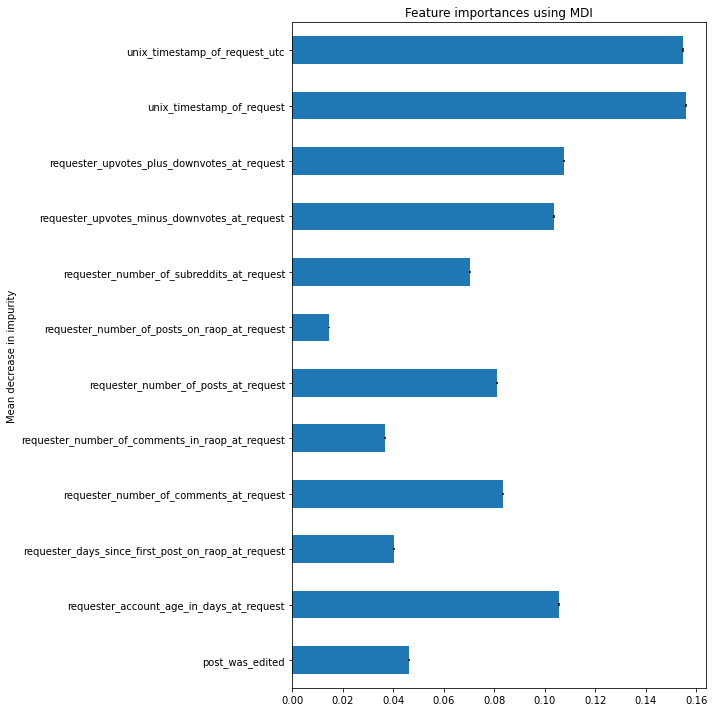

In [126]:
clf = RandomForestClassifier(bootstrap=True, max_depth=80,max_features=3,min_samples_leaf=3,min_samples_split=8,n_estimators=200)
clf.fit(X_train, y_train)

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
feature_names = list(X.columns)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,10))
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
#Add date and time breakout fields (day of week, time of day, etc)
#subreddits as proxy for account activity
#Binning net upvotes/downvotes 

In [128]:
data.columns

Index(['giver_username_if_known', 'post_was_edited', 'request_id',
       'request_text', 'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request', 'target',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_user_flair',
       'requester_username', 'unix_timestamp_of_request',
       'unix_timestamp_of_request_utc'],
      dtype='object')